In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
import rubin_sim.scheduler.basis_functions as bf
from rubin_sim.scheduler.features import Conditions
import rubin_sim.skybrightness_pre as skybrightness_pre
import rubin_sim.site_models as site_models
from rubin_sim.scheduler.model_observatory import ModelObservatory

In [3]:
nside = 32
mjd_start = 60676.0
observatory = ModelObservatory(nside=nside, mjd_start=mjd_start, init_load_length=5)

In [4]:
almanac = observatory.almanac
alm_night = np.where(almanac.sunsets['night'] == 0)
mjd = almanac.sunsets[alm_night]['sun_n18_setting']

In [5]:
observatory.mjd = mjd
conditions = observatory.return_conditions()

-6.4347355361511935 -17.99869278809098


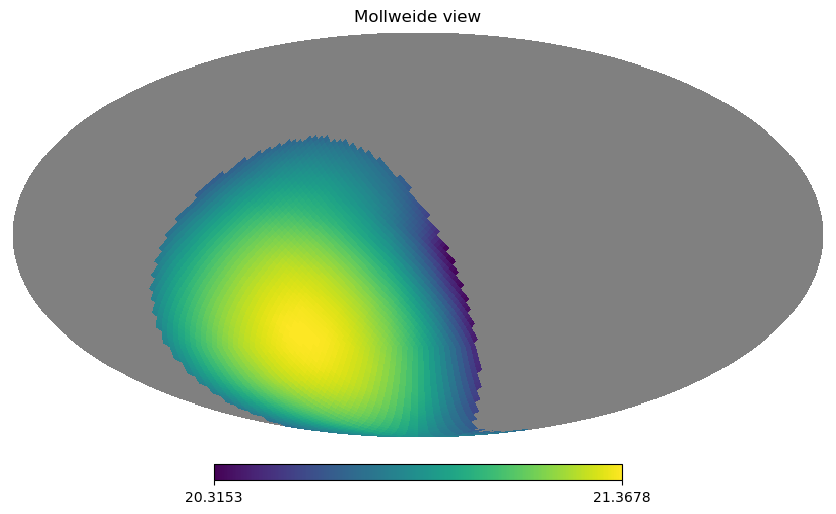

In [6]:
hp.mollview(conditions.skybrightness['r'])
# check the moon is down too .. looks normal
print(np.degrees(conditions.moon_alt), np.degrees(conditions.sun_alt))

In [7]:
# Make a way we can easily update the seeing (and depth) in the conditions
def update_seeing(conditions, fwhm_500, nside):
    airmass = np.where(conditions.airmass > 0, conditions.airmass, np.nan)
    conditions.fwhm_500 = fwhm_500
    seeing_model = site_models.SeeingModel()
    seeing_fwhm_eff = seeing_model(fwhm_500, airmass)['fwhmEff']
    for i, key in enumerate(seeing_model.filter_list):
        conditions.fwhm_eff[key] = seeing_fwhm_eff[i, :]
    conditions._fwhm_eff = conditions.fwhm_eff
    conditions.calc_m5_depth()
    return conditions

observatory.mjd = mjd
conditions = observatory.return_conditions()

fwhm_500_initial = conditions.fwhm_500
print('initial value', fwhm_500_initial, np.nanmin(conditions.fwhm_eff['g']), np.nanmax(conditions.m5_depth['g']))

conditions = update_seeing(conditions, fwhm_500_initial+0.2, nside)
print('after update', conditions.fwhm_500, np.nanmin(conditions.fwhm_eff['g']), np.nanmax(conditions.m5_depth['g']))


initial value [0.85306491] 1.1210081568956158 24.70819597047413
after update [1.05306491] 1.3427428005794728 24.51223582102018


In [8]:
# How does the maximum value of the basis function change as the fiducial FWHM is changed and as the fwhm_500 changes?
filterlist = 'ugrizy'

observatory.mjd = mjd
conditions = observatory.return_conditions()

fwhm500s = np.arange(0.3, 2.1, 0.1)
#fwhm500s = np.array([0.3, 0.7, 1.2])

max_values = {}
for seeing in ['good', 'fid', 'bad']:
    max_values[seeing] = {}
    for f in filterlist:
        max_values[seeing][f] = []

for seeing in ['good', 'fid', 'bad']:
    for f in filterlist:
        if seeing == 'good':
            ff = bf.M5DiffBasisFunction(filtername=f, fiducial_FWHMEff=0.3, nside=nside)
        elif seeing == 'fid':
            ff = bf.M5DiffBasisFunction(filtername=f, nside=nside)
        elif seeing =='bad':
            ff = bf.M5DiffBasisFunction(filtername=f, fiducial_FWHMEff=1.2, nside=nside)
        for fwhm500 in fwhm500s:
            conditions2 = update_seeing(conditions, fwhm500, nside)
            vv = np.nanmax(ff(conditions2))
            #print(f, fwhm500, conditions2.fwhm_500, np.nanmax(conditions2.fwhm_eff[f]), vv)
            max_values[seeing][f].append(vv)

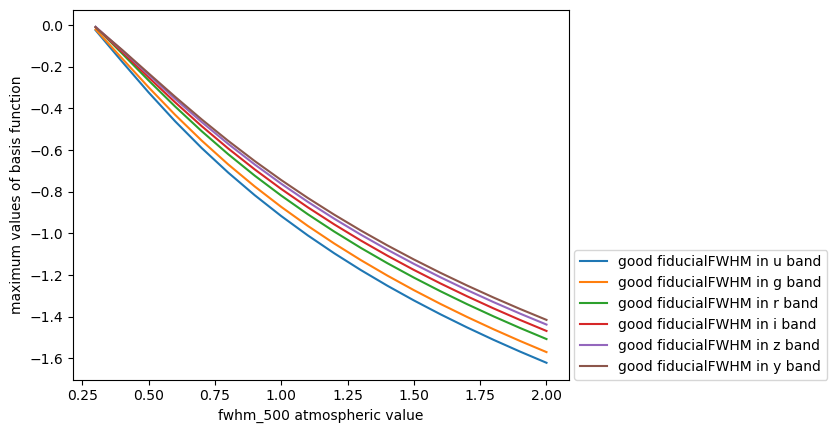

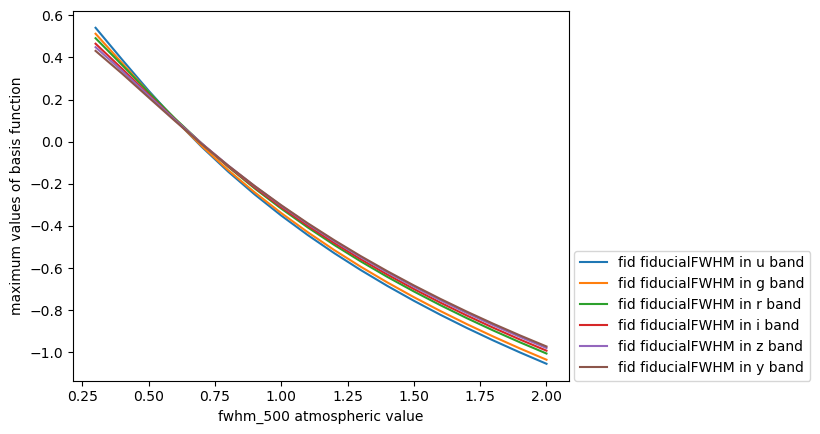

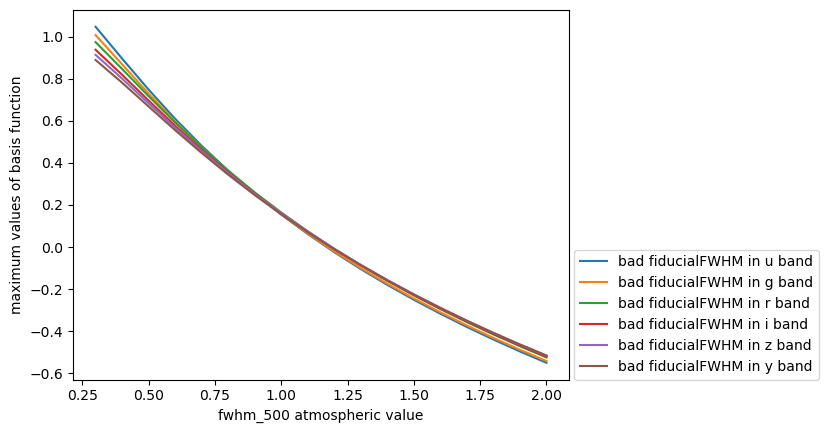

In [9]:
for seeing in ['good', 'fid', 'bad']:
    plt.figure()
    for f in filterlist:
        plt.plot(fwhm500s, max_values[seeing][f], label=f'{seeing} fiducialFWHM in {f} band')
    plt.legend(loc=(1.01, 0.0))
    plt.xlabel("fwhm_500 atmospheric value")
    plt.ylabel("maximum values of basis function")

Text(0, 0.5, 'maximum values of basis function')

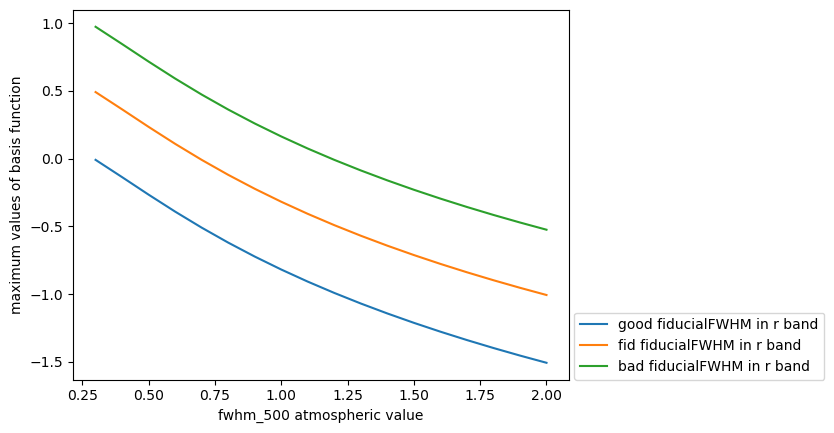

In [10]:
for seeing in ['good', 'fid', 'bad']:
    for f in ['r']: #filterlist:
        plt.plot(fwhm500s, max_values[seeing][f], label=f'{seeing} fiducialFWHM in {f} band')
plt.legend(loc=(1.01, 0.0))
plt.xlabel("fwhm_500 atmospheric value")
plt.ylabel("maximum values of basis function")

0.23433481490628338 -0.4911500018617545


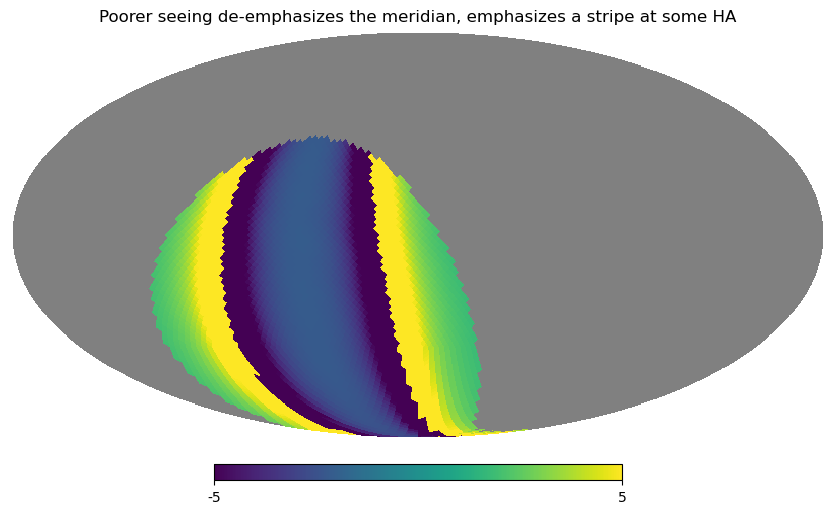

In [11]:
# Let's look at *shape* of basis function over the sky for two different FWHM_500 values, and different options of the fiducialFWHM 

observatory.mjd = mjd
conditions = observatory.return_conditions()

conditions = update_seeing(conditions, 0.5, nside)
tt = bf.M5DiffBasisFunction(filtername=f, fiducial_FWHMEff=0.7, nside=nside)(conditions)
conditions = update_seeing(conditions, 1.2, nside)
tt2 = bf.M5DiffBasisFunction(filtername=f, fiducial_FWHMEff=0.7, nside=nside)(conditions) 

hp.mollview(tt2/ tt, min=-5, max=5, title='Poorer seeing de-emphasizes the meridian, emphasizes a stripe at some HA')
print(np.nanmax(tt), np.nanmax(tt2))

0.9371727079402277 0.21168789117218978


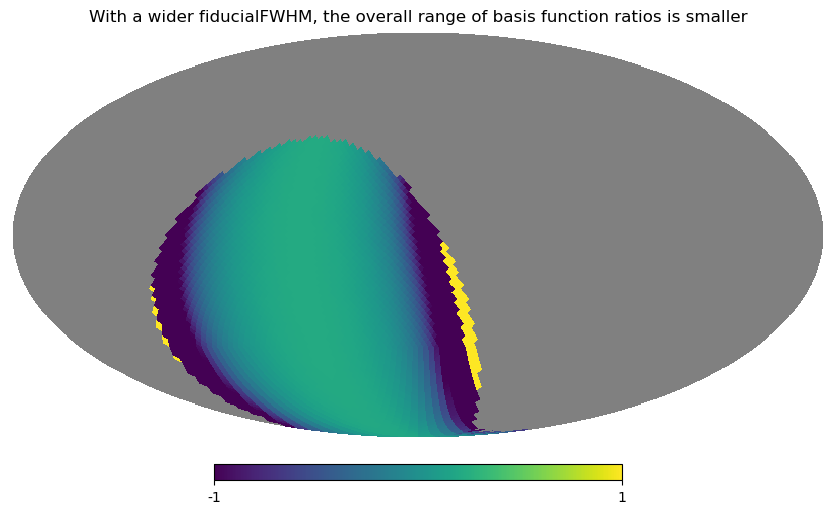

In [12]:
observatory.mjd = mjd
conditions = observatory.return_conditions()

conditions = update_seeing(conditions, 0.5, nside)
tt = bf.M5DiffBasisFunction(filtername=f, fiducial_FWHMEff=1.5, nside=nside)(conditions)
conditions = update_seeing(conditions, 1.2, nside)
tt2 = bf.M5DiffBasisFunction(filtername=f, fiducial_FWHMEff=1.5, nside=nside)(conditions) 
hp.mollview(tt2 / tt, min=-1, max=1, title='With a wider fiducialFWHM, the overall range of basis function ratios is smaller')
print(np.nanmax(tt), np.nanmax(tt2))

-0.2661246834050637 -0.9916095001731016


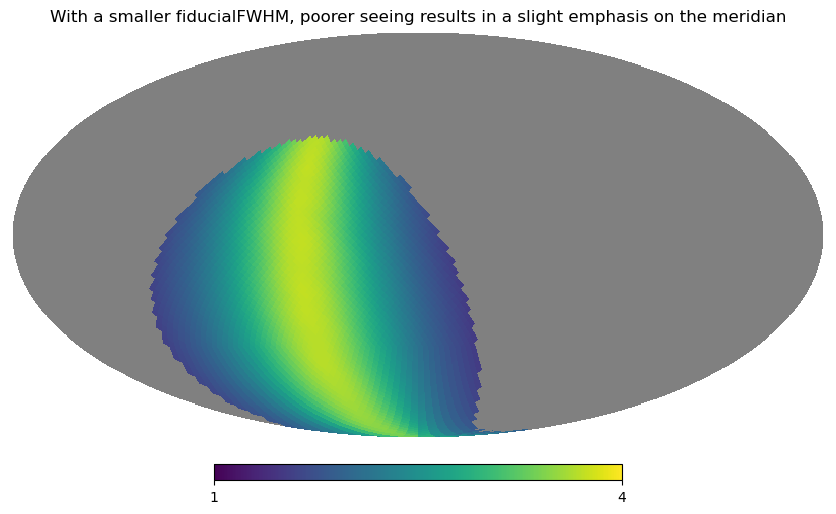

In [13]:
observatory.mjd = mjd
conditions = observatory.return_conditions()

conditions = update_seeing(conditions, 0.5, nside)
tt = bf.M5DiffBasisFunction(filtername=f, fiducial_FWHMEff=0.3, nside=nside)(conditions)
conditions = update_seeing(conditions, 1.2, nside)
tt2 = bf.M5DiffBasisFunction(filtername=f, fiducial_FWHMEff=0.3, nside=nside)(conditions) 
hp.mollview(tt2 / tt, min=1, max=4, title='With a smaller fiducialFWHM, poorer seeing results in a slight emphasis on the meridian')
print(np.nanmax(tt), np.nanmax(tt2))

0.18672920952097982 -0.009076163612363075


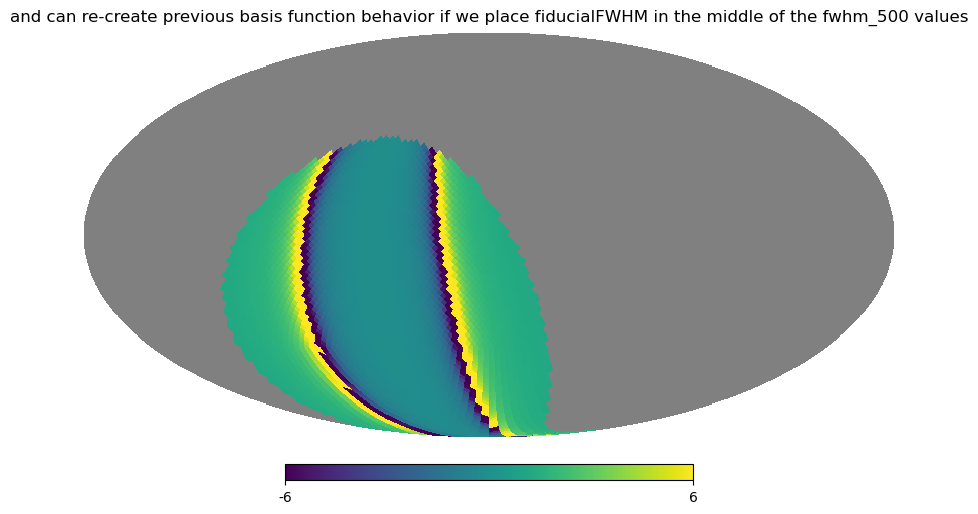

In [14]:
observatory.mjd = mjd
conditions = observatory.return_conditions()

conditions = update_seeing(conditions, 0.1, nside)
tt = bf.M5DiffBasisFunction(filtername=f, fiducial_FWHMEff=0.3, nside=nside)(conditions)
conditions = update_seeing(conditions, 0.3, nside)
tt2 = bf.M5DiffBasisFunction(filtername=f, fiducial_FWHMEff=0.3, nside=nside)(conditions) 
hp.mollview(tt2 / tt, min=-6, max=6, title='and can re-create previous basis function behavior if we place fiducialFWHM in the middle of the fwhm_500 values')
print(np.nanmax(tt), np.nanmax(tt2))

-0.2661246834050637 -0.9916095001731016


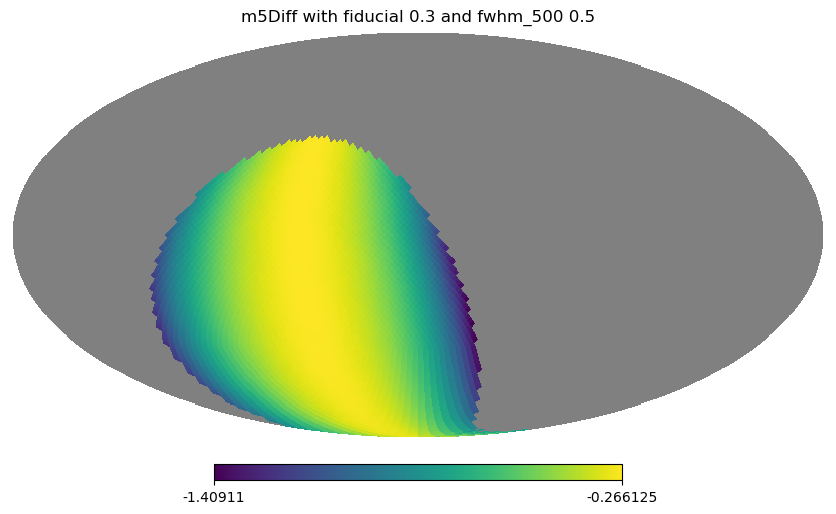

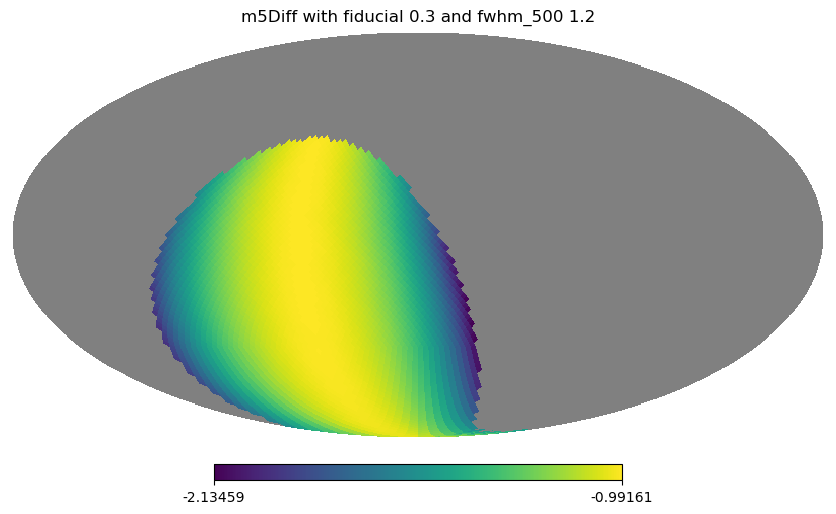

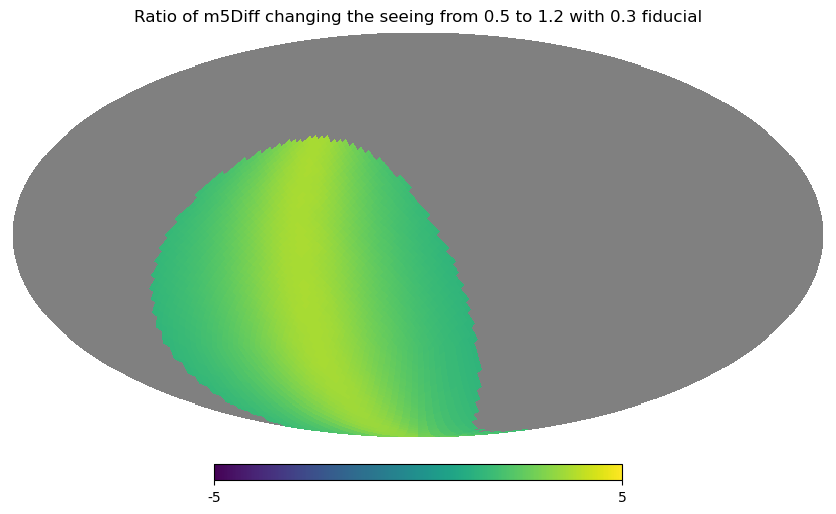

In [22]:
# The m5Diff basis function emphasizes meridian visits no matter what .. but if we are interested in the 
observatory.mjd = mjd
conditions = observatory.return_conditions()

fiducial_FWHM = 0.3
fwhm500a = 0.5
fwhm500b = 1.2
conditions = update_seeing(conditions, fwhm500a, nside)
tt = bf.M5DiffBasisFunction(filtername=f, fiducial_FWHMEff=fiducial_FWHM, nside=nside)(conditions)
conditions = update_seeing(conditions, fwhm500b, nside)
tt2 = bf.M5DiffBasisFunction(filtername=f, fiducial_FWHMEff=fiducial_FWHM, nside=nside)(conditions) 

hp.mollview(tt, title=f"m5Diff with fiducial {fiducial_FWHM} and fwhm_500 {fwhm500a}")
hp.mollview(tt2, title=f"m5Diff with fiducial {fiducial_FWHM} and fwhm_500 {fwhm500b}")
hp.mollview(tt2/ tt, min=-5, max=5, title=f'Ratio of m5Diff changing the seeing from {fwhm500a} to {fwhm500b} with {fiducial_FWHM} fiducial')
print(np.nanmax(tt), np.nanmax(tt2))